### Stochastic MPC with Recovery Initialization \& Indirect Feedback

This notebook showcases the usage of stochastic MPC (SMPC) with [recovery initialization](../ampyc/controllers/ri_smpc.py) [1] and [indirect feedback](../ampyc/controllers/if_smpc.py) [2]. The accompanying notes for this notebook are [here](../notes/07_stochasticMPC2.pdf).

[1] L. Hewing and M. N. Zeilinger, "Stochastic Model Predictive Control for Linear Systems Using Probabilistic Reachable Sets", Conference on Decision Control (CDC), 2018.

[2] L. Hewing, K. P. Wabersich, and M. N. Zeilinger, "Recursively feasible stochastic model predictive control using indirect feedback", Automatica, 2020.

In [1]:
# import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# import the default parameters, the linear system, and the two stochastic MPC controllers
from ampyc.params import SMPCParams
from ampyc.systems import LinearSystem
from ampyc.controllers import RecoveryInitializationSMPC, IndirectFeedbackSMPC

# import additional utilities from ampyc (plotting and RoA computation)
from ampyc.plotting import plot_x_state_time, plot_x_state_state, plot_u, plot_tubes
from ampyc.utils import compute_prs, compute_RoA

#### Probabilistic Reachable Sets
For both controllers, we will use probabilistic reachable sets (PRS), let's compute them. To do this, we first instantiate the linear system using the loaded default parameters.

In [2]:
params = SMPCParams()
sys = LinearSystem(params.sys)

Successfully initialized experiment 'stochastic linear MPC'.


Using a utility method from the AMPyC package, we can easily compute the PRS, including the resulting state and input constraint tightening, which we will use later in the controllers.

Please note that we need to compute the PRS for all simulation time steps plus the horizon. This is due to the fact that we need to shift the PRS in the SMPC! For more information please see the accompanying notes.

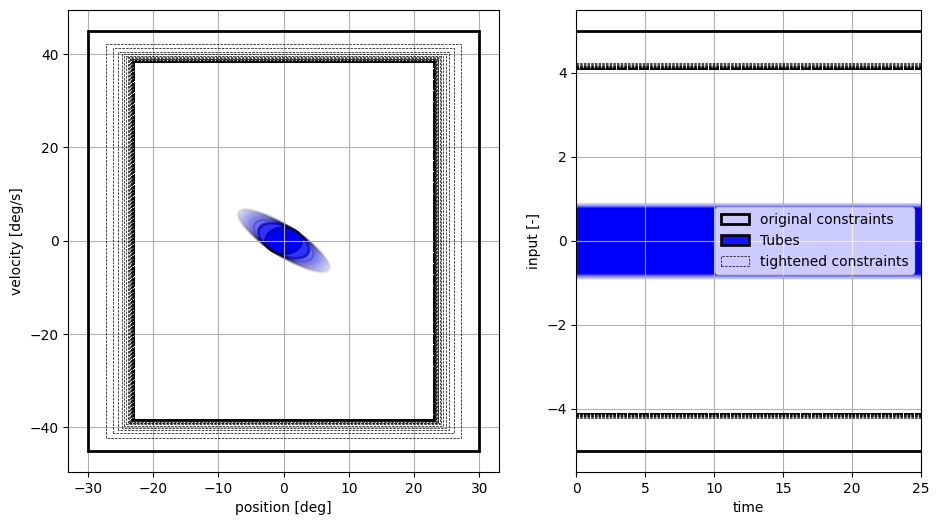

In [3]:
# compute the PRS for a given probability level p
p = 0.9
x_tight, u_tight, F, p_tilde, P, K = compute_prs(sys, p, params.sim.num_steps+params.ctrl.N)

# convert state sets to degrees for plotting
X_deg = (180/np.pi) * sys.X
F_deg = []
conversion_factor = (np.pi/180)**2
for F_i in F:
    F_deg += [conversion_factor/p_tilde * F_i] # also normalize by p_tilde

# undo conversion for tube controller
K_deg = np.sqrt(conversion_factor)*K

# plot
plot_tubes(1, F_deg, K_deg, X_deg, sys.U, params.plot, state_axes=['position [deg]', 'velocity [deg/s]'], input_axes=['input [-]'])

The PRS quickly converge to an infinite time step PRS, which we also plot below

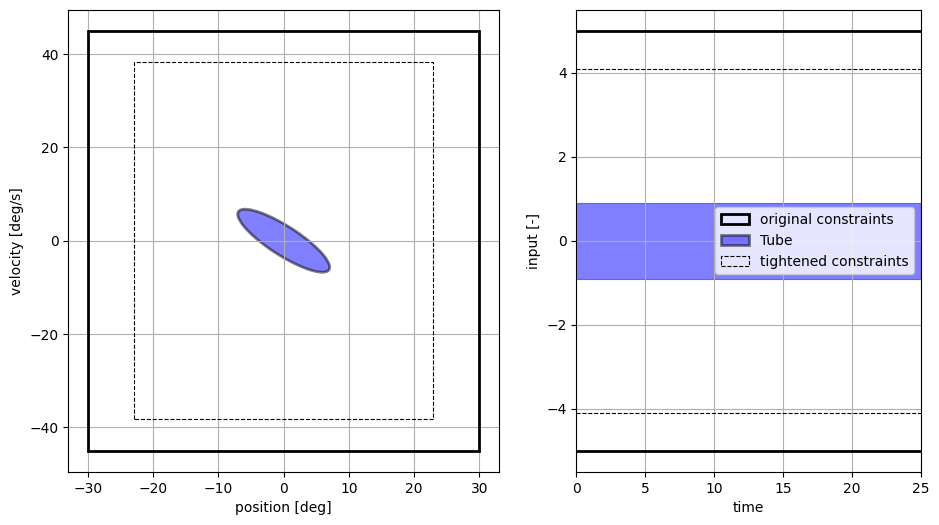

In [4]:
# plot the infinite time step PRS
params.plot.alpha = 0.5 # reset alpha for the next plot
plot_tubes(1, F_deg[-1], K_deg, X_deg, sys.U, params.plot, state_axes=['position [deg]', 'velocity [deg/s]'], input_axes=['input [-]'])

#### SMPC with Recovery Initialization
Next, we use the computed PRS to simulate SMPC with recovery initialization. Note that we need to continuously pass the state and input constraint tightening computed above to the SMPC controller, since the tubes and therefore the tightening is shifted in every time step!

In [5]:
# initialize the recovery initialization controller & pass the tube controller
ctrl_RI = RecoveryInitializationSMPC(sys, params.ctrl, K)

# set random seed for reproducibility
sys.noise_generator.seed(42)

# get the simulation parameters and the MPC horizon
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj
N = ctrl_RI.params.N

# get the initial state from the parameters
x_0 = params.sim.x_0

# allocate state and input trajectories plus a cost array
x = np.zeros((num_steps+1, sys.n, num_traj))
z = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
C = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0
z[0,:,:] = x_0

# simulate the closed-loop system
for i in range(num_traj):
    for j in range(num_steps):
        # pass the tightenings for the horizon to the optimizer as additional parameters
        tightenings = {
            'x_tight': x_tight[:, j:j+N],
            'u_tight': u_tight[:, j:j+N],
        }
        
        # Try to solve the MPC problem with the true current state
        u_bar, x_bar, error_msg = ctrl_RI.solve(x[j,:,i], additional_parameters=tightenings, verbose=False)
        
        # if the problem is infeasible, use the previously predicted nominal state and solve again
        if error_msg != None:
            u_bar, x_bar, error_msg_nom = ctrl_RI.solve(z[j,:,i], additional_parameters=tightenings, verbose=False)
            
            # check if the solver return an error message for the nominal state as well
            if error_msg_nom:
                raise Exception(error_msg_nom)
            
            # compute the control law
            pi = u_bar[:,0] + ctrl_RI.K @ (x[j,:,i] - z[j,:,i])
            u[j,i] = pi.item() # need .item(), since u is a scalar
        else:
            # directly use the control input from the MPC solution
            u[j,i] = u_bar[:,0].item() # need .item(), since u is a scalar
        
        # advance the system
        z[j+1,:,i] = x_bar[:,1]
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity
        
        # compute the closed-loop cost
        J = x[j,:,i].reshape(1,-1) @ ctrl_RI.params.Q @ x[j,:,i].reshape(-1,1)\
            + u[j,i].reshape(1,-1) @ ctrl_RI.params.R @ u[j,i].reshape(-1,1)
        C[j,i] = J.item() # need .item(), since J is a scalar

Then, we print the average closed-loop cost and plot the closed-loop trajectories. We do this in angular coordinates, since the system we are simulating is a simplified segway model.

Average incurred cost with recovery initialization:
18.38


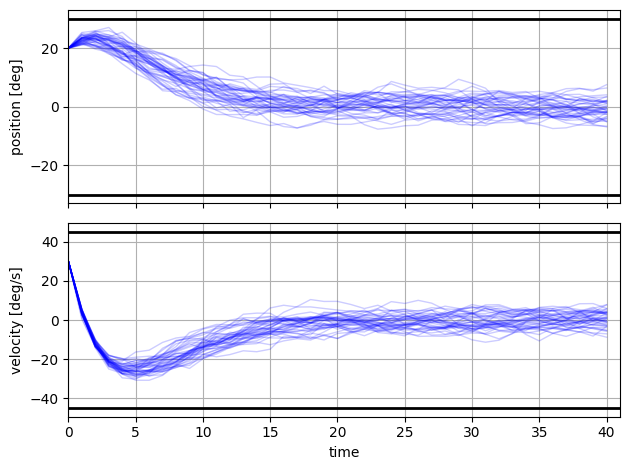

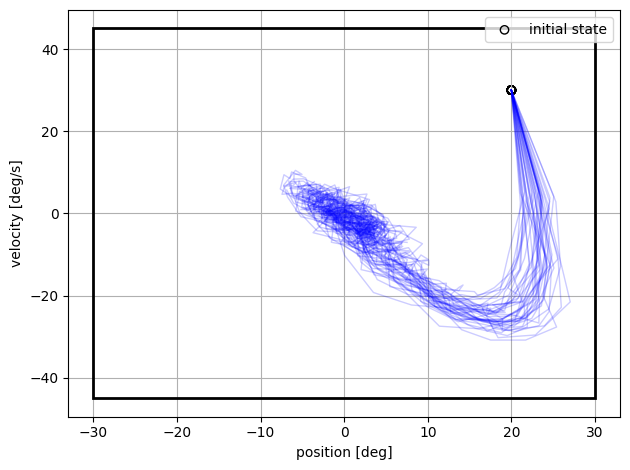

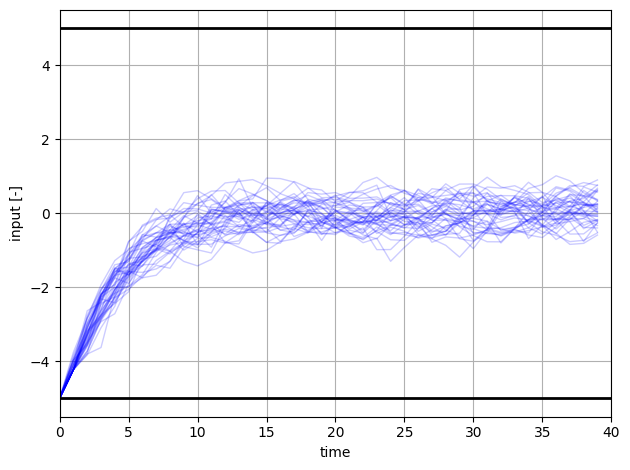

In [6]:
# print closed-loop cost
print('Average incurred cost with recovery initialization:\n{:.2f}'.format(C.mean()))

# convert states to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X

# plot closed-loop trajectories
params.plot.alpha = 0.2 # reset alpha for the next plot
plot_x_state_time(1, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, u, sys.U, params.plot, axes_labels=['input [-]'])

Finally, let's also check the region of attraction (RoA), i.e., the set of all initial states for which the MPC is feasible.

Note: We will only compute the RoA for recovery initialization SMPC, since the RoAs of both recovery initialization and indirect feedback SMPC are equivalent!

100%|██████████| 25/25 [00:02<00:00,  9.62it/s]


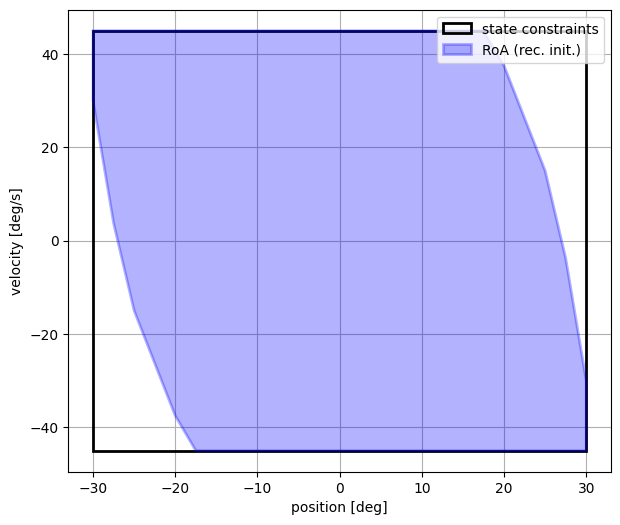

In [7]:
_, ax = plt.subplots(1, 1, figsize=(7, 6))

# compute the RoA; we also need to pass the tightenings as additional parameters, but only for the initial state (since we don't do a closed-loop simulation)
tightenings = {
            'x_tight': x_tight[:, 0:N],
            'u_tight': u_tight[:, 0:N],
        }
RoA = compute_RoA(ctrl_RI, sys, additional_params=tightenings)

# convert state constraints and the RoA to degrees for plotting
X_deg = (180/np.pi) * sys.X
RoA = (180/np.pi) * RoA

# plot the RoA and the state constraints
X_deg.plot(ax=ax, fill=False, color='black', alpha=1.0, linewidth=2, label='state constraints')
RoA.plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', linewidth=2, label='RoA (rec. init.)')

# set the axis labels and limits
ax.set_xlabel('position [deg]')
ax.set_ylabel('velocity [deg/s]')
ax.set_xlim(X_deg.xlim)
ax.set_ylim(X_deg.ylim)

# add a grid and the legend
plt.grid()
plt.legend(loc='upper right')
plt.show()

#### SMPC with Indirect Feedback
Now we do the same for SMPC with indirect feedback. Note that again we need to continuously pass the state and input constraint tightening to the SMPC controller.

In [8]:
# initialize the indirect feedback controller & pass the tube controller and LQR cost
ctrl_IF = IndirectFeedbackSMPC(sys, params.ctrl, P, K)

# set random seed for reproducibility
sys.noise_generator.seed(42)

# get the simulation parameters and the MPC horizon
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj
N = ctrl_IF.params.N

# get the initial state from the parameters
x_0 = params.sim.x_0

# allocate state and input trajectories plus a cost array
xx = np.zeros((num_steps+1, sys.n, num_traj))
zz = np.zeros((num_steps+1, sys.n, num_traj))
uu = np.zeros((num_steps, num_traj))
CC = np.zeros((num_steps, num_traj))
xx[0,:,:] = x_0
zz[0,:,:] = x_0

# simulate the closed-loop system
for i in range(num_traj):
    for j in range(num_steps):
        # pass the tightenings for the horizon and z_0 to the optimizer as additional parameters
        additional_params = {
            'x_tight': x_tight[:, j:j+N],
            'u_tight': u_tight[:, j:j+N],
            'z_0': zz[j,:,i],
        }
        
        # get the control input by solving the MPC problem
        u_bar, sol_z, error_msg = ctrl_IF.solve(xx[j,:,i], additional_parameters=additional_params, verbose=False)

        # check if the solver returned an error
        if error_msg != None:
            raise Exception(error_msg)
        
        # advance the system
        uu[j,i] = u_bar[:,0].item() # need .item(), since u is a scalar
        zz[j+1,:,i] = sol_z[:,1]
        xx[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity
        
        # compute the closed-loop cost
        J = xx[j,:,i].reshape(1,-1) @ ctrl_IF.params.Q @ xx[j,:,i].reshape(-1,1)\
            + uu[j,i].reshape(1,-1) @ ctrl_IF.params.R @ uu[j,i].reshape(-1,1)
        CC[j,i] = J.item() # need .item(), since J is a scalar

Then, we print the average closed-loop cost and plot the closed-loop trajectories. We again do this in angular coordinates.

Average incurred cost with indirect feedback:
17.80


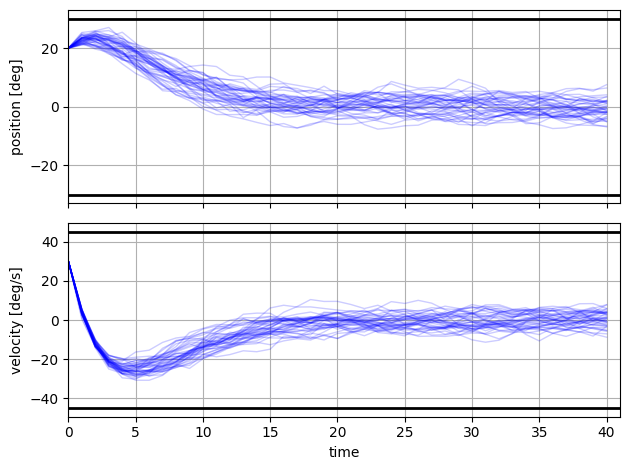

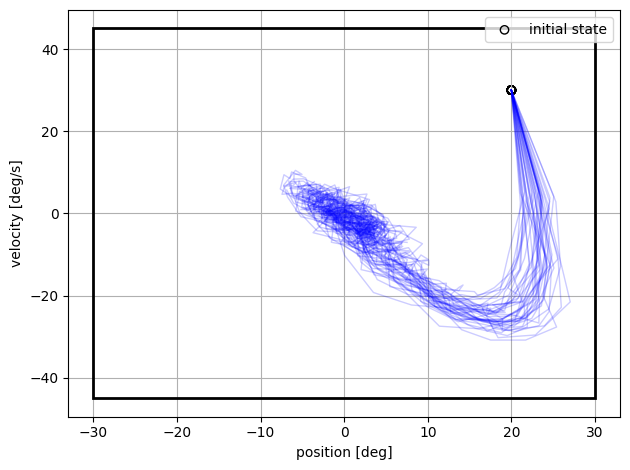

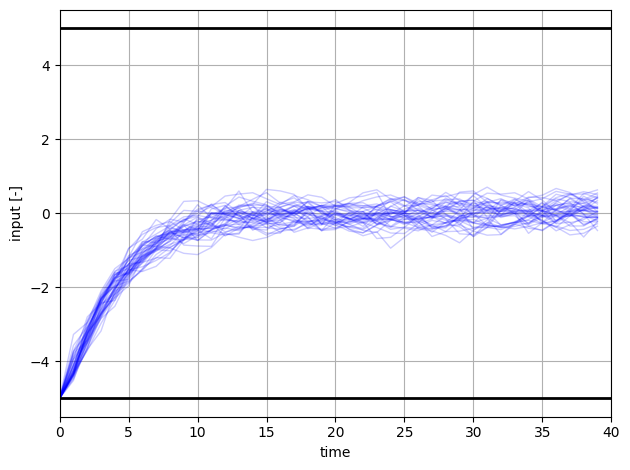

In [9]:
# print the closed-loop cost
print('Average incurred cost with indirect feedback:\n{:.2f}'.format(CC.mean()))

# convert states to degrees for plotting
xx_deg = np.rad2deg(xx)

# plot closed-loop trajectories
params.plot.alpha = 0.2 # reset alpha for the next plot
plot_x_state_time(1, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, uu, sys.U, params.plot, axes_labels=['input [-]'])

#### Compare the two controllers
Let's directly compare the closed-loop trajectories computed above

Cost improvement with indirect feedback:
3.26%


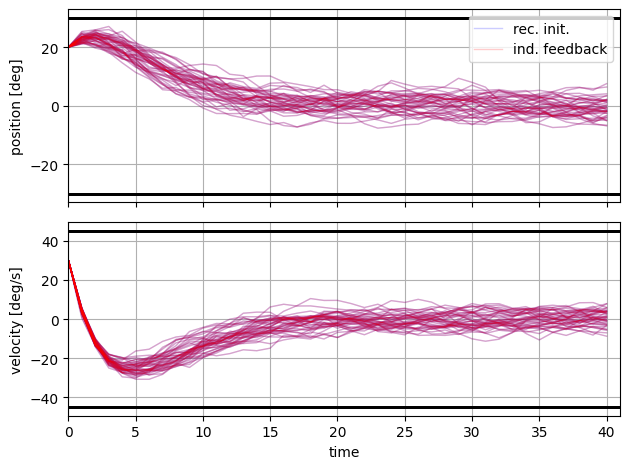

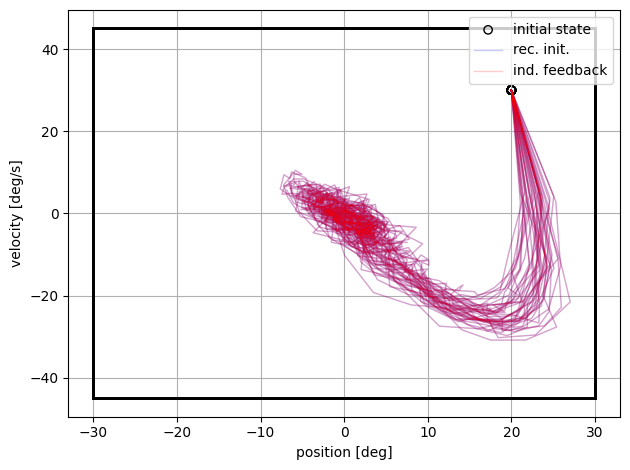

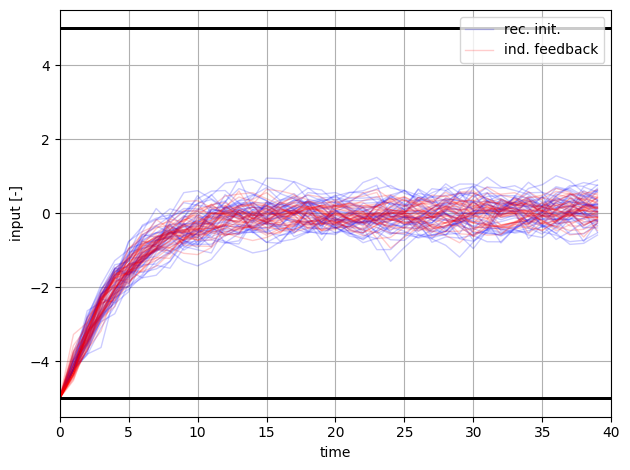

In [10]:
# print cost improvement
print('Cost improvement with indirect feedback:\n{:.2f}%'.format(100*(C.mean()-CC.mean())/CC.mean()))

# plot recovery initialization
params.plot.color = 'blue' # ensure plotting in blue (in case of rerunning the cell)
plot_x_state_time(1, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'], label='rec. init.')
plot_x_state_state(2, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'], label='rec. init.')
plot_u(3, u, sys.U, params.plot, axes_labels=['input [-]'], label='rec. init.')

# plot indirect feedback
params.plot.color = "red" # highlight indirect feedback in red
plot_x_state_time(1, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'], label='ind. feedback')
plot_x_state_state(2, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'], label='ind. feedback')
plot_u(3, uu, sys.U, params.plot, axes_labels=['input [-]'], label='ind. feedback')

We see that the trajectories almost perfectly overlap, except for the input, where the difference is clearer. This mainly explains the cost improvement for the indirect feedback approach.